In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
#pd.set_option("precision",4)

In [2]:
# df_betas: daily portfolio(P1 to P10, BAB) betas
# df_returns: daily portfolio(P1 to P10, BAB) returns

# US

## Market Data

In [3]:
df_CRSP_market_daily=pd.read_csv('../data/CRSP/CRSP Daily Index Built on Market Capitalization.csv',\
index_col=0,parse_dates=True)

In [4]:
df_CRSP_market_daily =df_CRSP_market_daily[['vwretd']]['2001-01-01':'2020-12-31']

In [5]:
df_AQR_risk_free_daily=pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Daily.xlsx',\
sheet_name='RF',header=18,index_col=0,parse_dates=True)
df_AQR_risk_free_daily= df_AQR_risk_free_daily['2001-01-01':'2020-12-31']

In [6]:
df_AQR_MKT_daily=pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Daily.xlsx',\
sheet_name='MKT',header=18,index_col=0,parse_dates=True)
df_AQR_MKT_daily= df_AQR_MKT_daily['2001-01-01':'2020-12-31']

In [7]:
df_FF_5=pd.read_csv('../data/FF_Factors/F-F_Research_Data_5_Factors_2x3_daily.csv',index_col=0,parse_dates=True)
df_FF_5 = df_FF_5['2001-01-01':'2020-12-31']/100

In [8]:
df_FF_5

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2001-01-02,-0.0352,0.0039,0.0165,0.0158,0.0161,0.00026
2001-01-03,0.0539,-0.0065,-0.0439,-0.0266,-0.0594,0.00026
2001-01-04,-0.0130,0.0097,-0.0030,0.0052,-0.0080,0.00026
2001-01-05,-0.0298,0.0071,0.0238,0.0190,0.0231,0.00026
2001-01-08,-0.0036,-0.0043,0.0126,0.0098,0.0067,0.00026
...,...,...,...,...,...,...
2020-12-24,0.0021,-0.0043,-0.0017,0.0024,-0.0005,0.00000
2020-12-28,0.0046,-0.0065,0.0032,0.0146,0.0050,0.00000
2020-12-29,-0.0040,-0.0142,0.0024,0.0075,-0.0028,0.00000


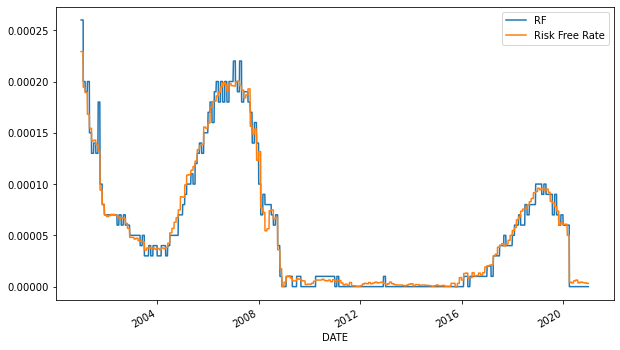

In [9]:
fig, ax =plt.subplots(figsize=(10,6))

df_FF_5.RF.plot(ax=ax)
(df_AQR_risk_free_daily).plot(ax=ax)

plt.legend()

In [10]:
dfs_market_merged=[df_FF_5[['Mkt-RF']],df_CRSP_market_daily[['vwretd']],df_AQR_MKT_daily[['USA']]]
dfs_market_merged=reduce(lambda x,y:pd.merge(x,y,left_index=True, right_index=True),dfs_market_merged)

<AxesSubplot:>

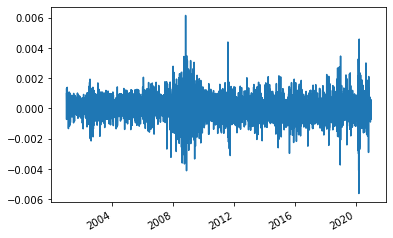

In [11]:
(dfs_market_merged['vwretd']-dfs_market_merged['Mkt-RF']).plot()

In [12]:
dfs_market_merged

,Mkt-RF,vwretd,USA
2001-01-02,-0.0352,-0.034230,-0.034543
2001-01-03,0.0539,0.053170,0.053313
2001-01-04,-0.0130,-0.011674,-0.010935
2001-01-05,-0.0298,-0.028909,-0.028499
2001-01-08,-0.0036,-0.003410,-0.003914
...,...,...,...
2020-12-24,0.0021,0.002332,0.002347
2020-12-28,0.0046,0.003870,0.003893
2020-12-29,-0.0040,-0.003649,-0.003812
2020-12-30,0.0027,0.003281,0.003364


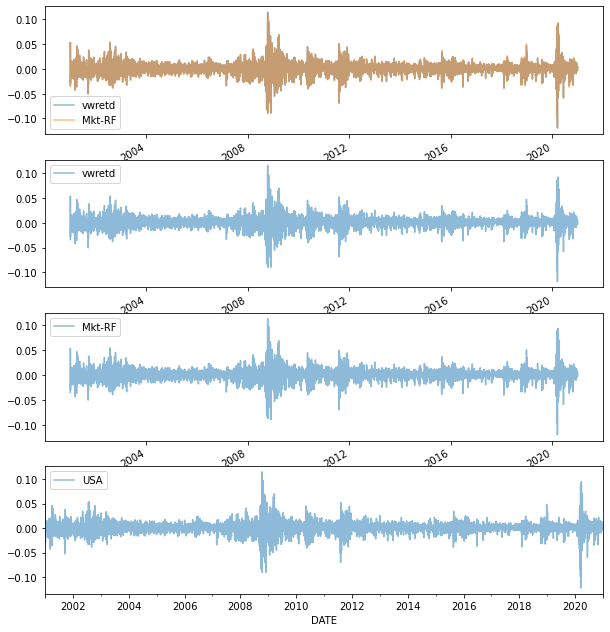

In [13]:
fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(10,12))

(df_CRSP_market_daily.vwretd).plot(ax=ax[0],alpha=0.5)
df_FF_5['Mkt-RF'].plot(ax=ax[0],alpha=0.5)

(df_CRSP_market_daily.vwretd).plot(ax=ax[1],alpha=0.5)

df_FF_5['Mkt-RF'].plot(ax=ax[2],alpha=0.5)

df_AQR_MKT_daily['USA'].plot(ax=ax[3],alpha=0.5)

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

## Construct the Table 3 and Table 4

In [60]:
def get_alpha(df, factors,portfolio):
    x = df[factors].copy()
    x = sm.add_constant(x)
    results = sm.OLS(df[portfolio], x).fit(cov_type='HC1')
    return results.params[0],results.params[1],results.tvalues[0]

In [61]:
df_betas=pd.read_pickle('../output/US/Portfolio Beta and Return Daily/beta.pickle')
df_returns=pd.read_pickle('../output/US/Portfolio Beta and Return Daily/return.pickle')
df_betas = df_betas.astype('float64')
df_returns = df_returns.astype('float64')

<AxesSubplot:>

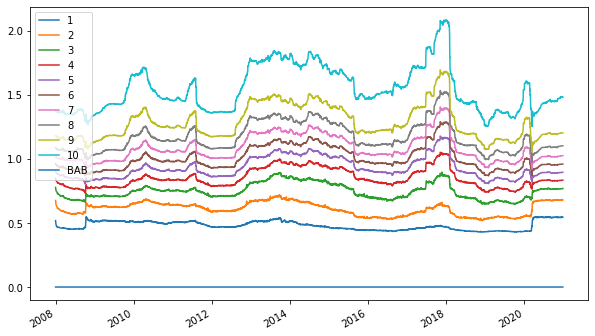

In [62]:
df_betas.rolling(1).mean().plot(figsize=(10,6))

<AxesSubplot:>

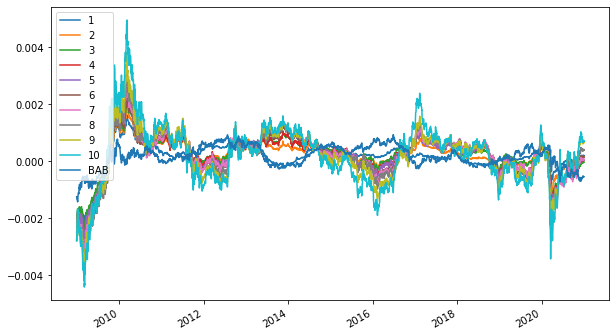

In [17]:
df_returns.rolling(252).mean().plot(figsize=(10,6))

In [18]:
df_Port_FF5=df_returns.merge(df_FF_5,left_index=True,right_index=True)
df_Port_FF5 = df_Port_FF5.dropna()

In [64]:
def get_table_3_4(df,df_beta):
    df_table_3=pd.DataFrame(index=['Excess Return','CAPM alpha','Three-factor alpha','Four-factor alpha',
                   'Five-factor alpha','Beta(ex ante)','Beta(realized)','Volatility','Sharpe Ratio'],
            columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','BAB'])
    df_table_4=pd.DataFrame(index=['CAPM alpha','Three-factor alpha','Four-factor alpha',
                   'Five-factor alpha'],
            columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','BAB'])
    
    columns = np.concatenate((np.arange(1,11,1), ['BAB'])).astype(str)

    df_table_3.loc[df_table_3.index=='Excess Return',:]=\
    ((((1+df).cumprod().iloc[-1,:11])**(252/len(df))-1)*100).values/12

    df_table_3.loc[df_table_3.index=='CAPM alpha',:]=\
    [(get_alpha(df,['Mkt-RF'],i)[0]*22)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Three-factor alpha',:]=\
    [(get_alpha(df,['Mkt-RF','SMB','HML'],i)[0]*22)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Four-factor alpha',:]=\
    [(get_alpha(df,['Mkt-RF','SMB','HML','RMW'],i)[0]*22)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Five-factor alpha',:]=\
    [(get_alpha(df,['Mkt-RF','SMB','HML','RMW','CMA'],i)[0]*22)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Beta(ex ante)',:]=\
    df_beta.mean().values

    df_table_3.loc[df_table_3.index=='Beta(realized)',:]=\
    [get_alpha(df,['Mkt-RF'],i)[1]*0.6+0.4 for i in columns]

    df_table_3.loc[df_table_3.index=='Volatility',:]=\
    [df[i].std()*np.sqrt(252)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Sharpe Ratio',:]=\
    (df_table_3.loc['Excess Return']*12/df_table_3.loc['Volatility'])[:].values
    
    df_table_4.loc[df_table_4.index=='CAPM alpha',:]=\
    [get_alpha(df,['Mkt-RF'],i)[2] for i in columns]

    df_table_4.loc[df_table_4.index=='Three-factor alpha',:]=\
    [get_alpha(df,['Mkt-RF','SMB','HML'],i)[2] for i in columns]

    df_table_4.loc[df_table_4.index=='Four-factor alpha',:]=\
    [get_alpha(df,['Mkt-RF','SMB','HML','RMW'],i)[2] for i in columns]

    df_table_4.loc[df_table_4.index=='Five-factor alpha',:]=\
    [get_alpha(df,['Mkt-RF','SMB','HML','RMW','CMA'],i)[2] for i in columns]

    return df_table_3,df_table_4

In [65]:
df_Port_FF5.index

DatetimeIndex(['2007-12-31', '2008-01-02', '2008-01-03', '2008-01-04',
               '2008-01-07', '2008-01-08', '2008-01-09', '2008-01-10',
               '2008-01-11', '2008-01-14',
               ...
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=3275, freq=None)

### All data: 2008-2020

In [73]:
start='2008-01-01'
end = '2020-12-31'
df_table_3,df_table_4 = get_table_3_4(df_Port_FF5[start:end],df_betas[start:end])

In [74]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,0.279424,0.305684,0.423402,0.269563,0.329263,0.185262,0.189931,0.0600736,0.0396385,-0.0897743,0.152649
CAPM alpha,0.10157,-0.0738014,-0.115881,-0.368155,-0.387966,-0.593558,-0.644955,-0.825569,-0.896584,-1.07665,0.629181
Three-factor alpha,0.127762,-0.0396989,-0.0883894,-0.340633,-0.336145,-0.519059,-0.541378,-0.680217,-0.708703,-0.766847,0.494107
Four-factor alpha,0.132249,-0.0298668,-0.0865887,-0.351641,-0.354216,-0.534837,-0.55062,-0.687838,-0.718141,-0.739656,0.508099
Five-factor alpha,0.136189,-0.029741,-0.091021,-0.355123,-0.351915,-0.530253,-0.542074,-0.674954,-0.695017,-0.705421,0.484484
Beta(ex ante),0.479212,0.609509,0.747277,0.849948,0.929285,1.00369,1.08158,1.16905,1.28325,1.54483,0
Beta(realized),0.530464,0.669173,0.787844,0.865922,0.937739,0.996547,1.06076,1.12244,1.20154,1.35044,0.170432
Volatility,8.61305,12.0215,15.3019,17.6474,20.096,22.232,24.7289,27.2414,30.5121,37.3824,13.8705
Sharpe Ratio,0.389304,0.305137,0.33204,0.1833,0.196614,0.0999975,0.092166,0.0264628,0.0155893,-0.0288181,0.132063


In [75]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,0.549236,-0.392405,-0.671029,-2.32151,-2.4167,-3.4763,-3.28331,-3.63836,-3.30662,-2.74289,2.25175
Three-factor alpha,0.704319,-0.221204,-0.555311,-2.51059,-2.90846,-4.97186,-5.05795,-6.03788,-5.00523,-3.17403,2.02077
Four-factor alpha,0.714678,-0.163183,-0.533895,-2.5515,-3.02452,-5.08607,-5.06053,-6.075,-5.03011,-3.0388,2.04616
Five-factor alpha,0.736019,-0.162846,-0.56234,-2.57648,-3.00962,-5.05348,-5.00741,-6.0303,-4.97987,-2.94818,1.96761


### Expansion Phrase: 2009-2019

In [76]:
start='2009-01-01'
end = '2019-12-31'
df_table_3,df_table_4 = get_table_3_4(df_Port_FF5[start:end],df_betas[start:end])

In [77]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,0.70395,0.830335,0.997346,0.875525,0.963483,0.828915,0.859253,0.657752,0.634377,0.560508,0.595821
CAPM alpha,0.554516,0.403151,0.291211,0.00237216,-0.0596939,-0.311313,-0.405664,-0.721072,-0.872304,-1.16088,1.30426
Three-factor alpha,0.569358,0.452695,0.346469,0.0730201,0.045982,-0.167212,-0.222451,-0.493991,-0.599904,-0.762467,1.12819
Four-factor alpha,0.569861,0.459836,0.346992,0.0642181,0.0321846,-0.176112,-0.225241,-0.49319,-0.591424,-0.703237,1.11512
Five-factor alpha,0.569271,0.4457,0.326978,0.043448,0.0225646,-0.178387,-0.215927,-0.475437,-0.558847,-0.665343,1.06585
Beta(ex ante),0.475942,0.607021,0.751801,0.858873,0.940224,1.01629,1.09629,1.18624,1.30337,1.57137,0
Beta(realized),0.476316,0.60909,0.746886,0.839186,0.918827,0.989787,1.06304,1.13883,1.22291,1.38603,0.0986232
Volatility,4.88617,7.26426,10.6439,12.9945,15.1168,17.1196,19.2716,21.5692,24.1727,29.8469,11.0815
Sharpe Ratio,1.72884,1.37165,1.12442,0.808521,0.764832,0.581028,0.535039,0.365939,0.314922,0.225353,0.645203


In [36]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,4.65168,3.32745,2.37799,0.0198144,-0.496044,-2.38646,-2.73189,-4.15405,-4.22465,-3.71255,6.60762
Three-factor alpha,4.77517,3.87086,3.03766,0.710528,0.52742,-2.10733,-2.78624,-5.50139,-5.22513,-3.56751,6.57558
Four-factor alpha,4.76962,3.94715,3.03607,0.62379,0.368818,-2.21684,-2.80916,-5.46543,-5.13553,-3.32451,6.50959
Five-factor alpha,4.76132,3.82117,2.87722,0.426006,0.259375,-2.24887,-2.71116,-5.34836,-4.99721,-3.18819,6.36146


### 2009-2020

In [78]:
start='2009-01-01'
end = '2020-12-31'
df_table_3,df_table_4 = get_table_3_4(df_Port_FF5[start:end],df_betas[start:end])

In [79]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,0.669014,0.759165,0.861087,0.759212,0.832459,0.724777,0.72505,0.59697,0.602486,0.490107,0.425794
CAPM alpha,0.426248,0.210296,0.0478816,-0.20863,-0.271621,-0.481677,-0.586037,-0.809726,-0.91406,-1.19276,1.034
Three-factor alpha,0.461267,0.276611,0.124508,-0.114295,-0.128727,-0.295483,-0.349463,-0.506832,-0.536591,-0.627301,0.785884
Four-factor alpha,0.453655,0.271067,0.113758,-0.130333,-0.147261,-0.308225,-0.356592,-0.511678,-0.540236,-0.596845,0.772435
Five-factor alpha,0.457276,0.26687,0.106932,-0.136618,-0.145327,-0.30135,-0.341975,-0.490585,-0.504838,-0.547638,0.734305
Beta(ex ante),0.479763,0.610674,0.751555,0.855937,0.93592,1.01106,1.08989,1.17861,1.29464,1.56122,0
Beta(realized),0.51796,0.661192,0.789274,0.870707,0.942906,1.00342,1.06723,1.13099,1.2085,1.35826,0.167928
Volatility,7.1846,10.4885,13.739,15.9021,18.1039,20.0372,22.2868,24.5928,27.5748,34.0521,12.225
Sharpe Ratio,1.11741,0.86857,0.752096,0.572914,0.551787,0.43406,0.390393,0.29129,0.26219,0.172714,0.417958


In [80]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,2.45466,1.11131,0.268855,-1.28306,-1.64893,-2.81349,-2.96429,-3.61461,-3.35506,-2.96922,3.94239
Three-factor alpha,2.83066,1.60668,0.785916,-0.836776,-1.09678,-2.89975,-3.32459,-4.60986,-3.82863,-2.55452,3.51451
Four-factor alpha,2.73715,1.54513,0.706614,-0.943691,-1.24618,-3.00711,-3.34679,-4.62397,-3.82013,-2.42157,3.41066
Five-factor alpha,2.78086,1.53365,0.668932,-0.99236,-1.2377,-2.96539,-3.25737,-4.54115,-3.703,-2.2709,3.31228


## BAB Factor Comparison

In [ ]:
df_AQR_BAB_daily=pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Daily.xlsx',\
sheet_name='BAB Factors',header=18,index_col=0,parse_dates=True)
df_AQR_BAB_daily = df_AQR_BAB_daily['2007-12-31':'2020-12-31']

In [81]:
df_BAB_comparison=df_AQR_BAB_daily[['USA']].merge(df_returns[['BAB']],left_index=True,right_index=True)

NameError: name 'df_AQR_BAB_daily' is not defined

In [ ]:
fig, ax =plt.subplots(figsize=(10,6))

df_BAB_comparison['USA'].plot(ax=ax,label='BAB by AQR')
df_BAB_comparison['BAB'].plot(ax=ax,label='BAB by Our Team',alpha=0.6)

plt.legend()

In [ ]:
fig, ax =plt.subplots(nrows=3,ncols=1,figsize=(10,12))

df_BAB_comparison['USA'].plot(ax=ax[0],label='BAB by AQR')
df_BAB_comparison['BAB'].plot(ax=ax[0],label='BAB by Our Team',alpha=0.5)
df_BAB_comparison['USA'].plot(ax=ax[1],label='BAB by AQR')
df_BAB_comparison['BAB'].plot(ax=ax[2],label='BAB by Our Team')


ax[0].legend()
ax[1].legend()
ax[2].legend()


# China

## Construct the Table 3 and Table 4

In [ ]:
df_betas=pd.read_pickle('../output/China/Portfolio Beta and Return Daily/beta.pickle')
df_returns=pd.read_pickle('../output/China/Portfolio Beta and Return Daily/return.pickle')
df_betas = df_betas.astype('float64')
df_returns = df_returns.astype('float64')

In [ ]:
df_betas.rolling(252).mean().plot(figsize=(10,6))

In [ ]:
df_betas.loc['2018-01-01':'2018-12-31'].rolling(1).mean().plot(figsize=(10,6)) # Check if extreme beta still exists

In [ ]:
df_returns.rolling(252).mean().plot(figsize=(10,6))

In [ ]:
df_Port_FF5=df_returns.merge(df_FF_5,left_index=True,right_index=True)
df_Port_FF5 = df_Port_FF5.dropna()

In [ ]:
df_Port_FF5.index

### All data: 2008-2020

In [73]:
start='2008-01-01'
end = '2020-12-31'
df_table_3,df_table_4 = get_table_3_4(df_Port_FF5[start:end],df_betas[start:end])

In [74]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,0.279424,0.305684,0.423402,0.269563,0.329263,0.185262,0.189931,0.0600736,0.0396385,-0.0897743,0.152649
CAPM alpha,0.10157,-0.0738014,-0.115881,-0.368155,-0.387966,-0.593558,-0.644955,-0.825569,-0.896584,-1.07665,0.629181
Three-factor alpha,0.127762,-0.0396989,-0.0883894,-0.340633,-0.336145,-0.519059,-0.541378,-0.680217,-0.708703,-0.766847,0.494107
Four-factor alpha,0.132249,-0.0298668,-0.0865887,-0.351641,-0.354216,-0.534837,-0.55062,-0.687838,-0.718141,-0.739656,0.508099
Five-factor alpha,0.136189,-0.029741,-0.091021,-0.355123,-0.351915,-0.530253,-0.542074,-0.674954,-0.695017,-0.705421,0.484484
Beta(ex ante),0.479212,0.609509,0.747277,0.849948,0.929285,1.00369,1.08158,1.16905,1.28325,1.54483,0
Beta(realized),0.530464,0.669173,0.787844,0.865922,0.937739,0.996547,1.06076,1.12244,1.20154,1.35044,0.170432
Volatility,8.61305,12.0215,15.3019,17.6474,20.096,22.232,24.7289,27.2414,30.5121,37.3824,13.8705
Sharpe Ratio,0.389304,0.305137,0.33204,0.1833,0.196614,0.0999975,0.092166,0.0264628,0.0155893,-0.0288181,0.132063


In [75]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,0.549236,-0.392405,-0.671029,-2.32151,-2.4167,-3.4763,-3.28331,-3.63836,-3.30662,-2.74289,2.25175
Three-factor alpha,0.704319,-0.221204,-0.555311,-2.51059,-2.90846,-4.97186,-5.05795,-6.03788,-5.00523,-3.17403,2.02077
Four-factor alpha,0.714678,-0.163183,-0.533895,-2.5515,-3.02452,-5.08607,-5.06053,-6.075,-5.03011,-3.0388,2.04616
Five-factor alpha,0.736019,-0.162846,-0.56234,-2.57648,-3.00962,-5.05348,-5.00741,-6.0303,-4.97987,-2.94818,1.96761


### Expansion Phrase: 2009-2019

In [76]:
start='2009-01-01'
end = '2019-12-31'
df_table_3,df_table_4 = get_table_3_4(df_Port_FF5[start:end],df_betas[start:end])

In [77]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,0.70395,0.830335,0.997346,0.875525,0.963483,0.828915,0.859253,0.657752,0.634377,0.560508,0.595821
CAPM alpha,0.554516,0.403151,0.291211,0.00237216,-0.0596939,-0.311313,-0.405664,-0.721072,-0.872304,-1.16088,1.30426
Three-factor alpha,0.569358,0.452695,0.346469,0.0730201,0.045982,-0.167212,-0.222451,-0.493991,-0.599904,-0.762467,1.12819
Four-factor alpha,0.569861,0.459836,0.346992,0.0642181,0.0321846,-0.176112,-0.225241,-0.49319,-0.591424,-0.703237,1.11512
Five-factor alpha,0.569271,0.4457,0.326978,0.043448,0.0225646,-0.178387,-0.215927,-0.475437,-0.558847,-0.665343,1.06585
Beta(ex ante),0.475942,0.607021,0.751801,0.858873,0.940224,1.01629,1.09629,1.18624,1.30337,1.57137,0
Beta(realized),0.476316,0.60909,0.746886,0.839186,0.918827,0.989787,1.06304,1.13883,1.22291,1.38603,0.0986232
Volatility,4.88617,7.26426,10.6439,12.9945,15.1168,17.1196,19.2716,21.5692,24.1727,29.8469,11.0815
Sharpe Ratio,1.72884,1.37165,1.12442,0.808521,0.764832,0.581028,0.535039,0.365939,0.314922,0.225353,0.645203


In [36]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,4.65168,3.32745,2.37799,0.0198144,-0.496044,-2.38646,-2.73189,-4.15405,-4.22465,-3.71255,6.60762
Three-factor alpha,4.77517,3.87086,3.03766,0.710528,0.52742,-2.10733,-2.78624,-5.50139,-5.22513,-3.56751,6.57558
Four-factor alpha,4.76962,3.94715,3.03607,0.62379,0.368818,-2.21684,-2.80916,-5.46543,-5.13553,-3.32451,6.50959
Five-factor alpha,4.76132,3.82117,2.87722,0.426006,0.259375,-2.24887,-2.71116,-5.34836,-4.99721,-3.18819,6.36146


### 2009-2020

In [78]:
start='2009-01-01'
end = '2020-12-31'
df_table_3,df_table_4 = get_table_3_4(df_Port_FF5[start:end],df_betas[start:end])

In [79]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,0.669014,0.759165,0.861087,0.759212,0.832459,0.724777,0.72505,0.59697,0.602486,0.490107,0.425794
CAPM alpha,0.426248,0.210296,0.0478816,-0.20863,-0.271621,-0.481677,-0.586037,-0.809726,-0.91406,-1.19276,1.034
Three-factor alpha,0.461267,0.276611,0.124508,-0.114295,-0.128727,-0.295483,-0.349463,-0.506832,-0.536591,-0.627301,0.785884
Four-factor alpha,0.453655,0.271067,0.113758,-0.130333,-0.147261,-0.308225,-0.356592,-0.511678,-0.540236,-0.596845,0.772435
Five-factor alpha,0.457276,0.26687,0.106932,-0.136618,-0.145327,-0.30135,-0.341975,-0.490585,-0.504838,-0.547638,0.734305
Beta(ex ante),0.479763,0.610674,0.751555,0.855937,0.93592,1.01106,1.08989,1.17861,1.29464,1.56122,0
Beta(realized),0.51796,0.661192,0.789274,0.870707,0.942906,1.00342,1.06723,1.13099,1.2085,1.35826,0.167928
Volatility,7.1846,10.4885,13.739,15.9021,18.1039,20.0372,22.2868,24.5928,27.5748,34.0521,12.225
Sharpe Ratio,1.11741,0.86857,0.752096,0.572914,0.551787,0.43406,0.390393,0.29129,0.26219,0.172714,0.417958


In [80]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,2.45466,1.11131,0.268855,-1.28306,-1.64893,-2.81349,-2.96429,-3.61461,-3.35506,-2.96922,3.94239
Three-factor alpha,2.83066,1.60668,0.785916,-0.836776,-1.09678,-2.89975,-3.32459,-4.60986,-3.82863,-2.55452,3.51451
Four-factor alpha,2.73715,1.54513,0.706614,-0.943691,-1.24618,-3.00711,-3.34679,-4.62397,-3.82013,-2.42157,3.41066
Five-factor alpha,2.78086,1.53365,0.668932,-0.99236,-1.2377,-2.96539,-3.25737,-4.54115,-3.703,-2.2709,3.31228
